**Instructors**: Prof. Keith Chugg (chugg@usc.edu)

**Notebook**: Written by Prof. Keith Chugg.

# Binary Linear Classifiers for MNIST (and Fashion MNIST) Dataset
In this notebook, we explore the MNIST and FashionMNIST datasers.  The MNIST dataset is for handwritten digits (0, 1, 2 .. 9) so it has 10 classes.  The Fashion MNIST dataset is the same size and format as MNIST, but it comprises images of clothing.  Although these datsets have 10 classes, we can extract two of these classes and consider the associated two-class classifier.  We consider MSE and Nearest Means binary classifiers and will extend to other optimiztion criteria.  

We will use `torchvision` which is a helper library for `PyTorch` to get the dataset and will use image tools `cv2` and `imutils` to inspect the data.  To add these to your `conda` environment, you need to install `opencv-python` (for `import cv2`) and `imutils`.  You may need to use `pip install` nstead of `conda install` depending on your compute platform.  

In [9]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets
import cv2
from imutils import build_montages


## Accessing and Inspecting the Data
First, let's get a function to get the MNIST or FMNIST data.

In [10]:
def load_MNIST_data(data_path, fashion=False, quiet=False):
    if not fashion:
        train_set = datasets.MNIST(data_path, download=True, train=True)
        test_set = datasets.MNIST(data_path, download=True, train=False)
    else:
        train_set = datasets.FashionMNIST(data_path, download=True, train=True)
        test_set = datasets.FashionMNIST(data_path, download=True, train=False)      
    x_train = train_set.data.numpy()
    y_train = train_set.targets.numpy()

    x_test = test_set.data.numpy()
    y_test = test_set.targets.numpy()
    
    N_train, H, W = x_train.shape
    N_test, H, W = x_test.shape

    if not quiet:
        print(f'The data are {H} x {W} grayscale images.')
        print(f'N_train = {N_train}')
        print(f'N_test = {N_test}')
    for i in set(y_train):
        N_i_train = np.sum(y_train==i)
        N_i_test = np.sum(y_test==i)
        if not quiet:
            print(f'Class {i}: has {N_i_train} train images ({100 * N_i_train / N_train : .2f} %), {N_i_test} test images ({100 * N_i_test/ N_test : .2f} %) ')
    return x_train, y_train, x_test, y_test

In [11]:
USE_FASHION_MNIST = False
if USE_FASHION_MNIST:
    tag_name = 'FashionMNIST'
else:
    tag_name = 'MNIST'
    
x_train, y_train, x_test, y_test = load_MNIST_data('./data/', fashion=USE_FASHION_MNIST, quiet=False)

The data are 28 x 28 grayscale images.
N_train = 60000
N_test = 10000
Class 0: has 5923 train images ( 9.87 %), 980 test images ( 9.80 %) 
Class 1: has 6742 train images ( 11.24 %), 1135 test images ( 11.35 %) 
Class 2: has 5958 train images ( 9.93 %), 1032 test images ( 10.32 %) 
Class 3: has 6131 train images ( 10.22 %), 1010 test images ( 10.10 %) 
Class 4: has 5842 train images ( 9.74 %), 982 test images ( 9.82 %) 
Class 5: has 5421 train images ( 9.04 %), 892 test images ( 8.92 %) 
Class 6: has 5918 train images ( 9.86 %), 958 test images ( 9.58 %) 
Class 7: has 6265 train images ( 10.44 %), 1028 test images ( 10.28 %) 
Class 8: has 5851 train images ( 9.75 %), 974 test images ( 9.74 %) 
Class 9: has 5949 train images ( 9.91 %), 1009 test images ( 10.09 %) 


Below is a helper function that will allow us to randomly sample from this data set and see what they look like.

In [12]:
def create_montage(x_data, y_labels, label_names, fname, true_labels=None, N=4):
    # initialize our list of output images
    images = []

    # randomly select a few images
    for i in np.random.choice(np.arange(0, len(y_labels)), size=(N * N,)):
        sample_image = x_data[i]
        sample_label = y_labels[i]
        sample_label_name = label_names[sample_label]
        # image = (sample_image * 255).astype("uint8")
        # initialize the text label color as green (correct)
        color = (0, 255, 0)
        if true_labels is not None and sample_label != true_labels[i]:
            # color red if an error has occcurred (when y_labels are predictions)
            color = (0, 0, 255)
        # merge the channels into one image and resize the image from
        # 28x28 to 96x96 so we can better see it and then draw the
        # predicted label on the image
        image = cv2.merge([sample_image] * 3)
        image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
        cv2.putText(image, sample_label_name, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
        # add the image to our list of output images
        images.append(image)

        # construct the montage for the images
        montage = build_montages(images, (96, 96), (N, N))[0]
        cv2.imwrite(fname, montage)

In [13]:
if USE_FASHION_MNIST:
    label_names = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
else:
    label_names = [f'{i}' for i in set(y_test)]

fname = f'./img/train_{tag_name}.png'

create_montage(x_train, y_train, label_names, fname, N=5)

## Binary Classification
We can extract any two classes from the data and try out some binary classification algorithms.

In [14]:
def extract_two_classes(x, labels, class_1, class_2):
    x_1 = x[labels==class_1]
    y_1 = np.ones(x_1.shape[0], dtype=int) * class_1
    x_2 = x[labels==class_2]
    y_2 = np.ones(x_2.shape[0], dtype=int) * class_2
    
    x_shape = x.shape
    N1 = len(y_1)
    N2 = len(y_2)
    N_12 = N1 + N2
    x_12 = np.zeros((N_12, x_shape[1], x_shape[2]))
    x_12[:N1] = x_1
    x_12[N1:] = x_2

    print(f'Class {class_1}: has {N1} images ({100 * N1 / (N_12) : .2f} %)')
    print(f'Class {class_2}: has {N2} images ({100 * N2 / (N_12) : .2f} %)')

    return x_12, np.append(y_1, y_2)

### Extracting and Visualizing Two classes
First let's try class two classes from the dataset.  If we consider class `0` and class `1`, this is a relatively easy problem.  For MNIST, these are the digits `0` and `1` and for FashionMNIST, these are `top`, `trouser`.  In both cases, this represents a represents a pair that are relatively easy to distinguish.  A relatively more difficult to classify between `3` and `5` in MNIST or `2` (`pullover`) and `6` (`shirt`) in FashionMNIST.  FashionMNIST was created as a more difficult version of MNIST.  

Before we train anything, we need to flatten the images to an array.  The images are 28 x 28 pixels, so the flattened arrays will have length 784.  Let's do that and then vsiualize some of these vectors to see if the two classes are easily distingiushed visually from these rastorized scans.  

Class 3: has 6131 images ( 51.17 %)
Class 8: has 5851 images ( 48.83 %)
Class 3: has 1010 images ( 50.91 %)
Class 8: has 974 images ( 49.09 %)


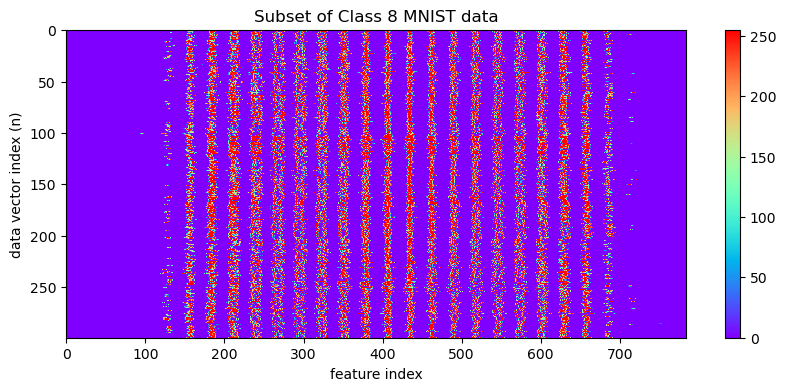

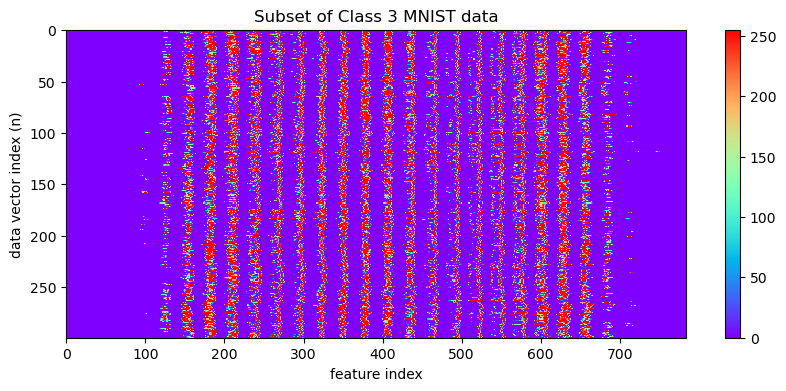

In [15]:
## change these to perform classification between different classes in the selected dataset.
c1 = 4
c2 = 9

x12_train, y12_train = extract_two_classes(x_train, y_train, c1, c2)
x12_test, y12_test = extract_two_classes(x_test, y_test, c1, c2)

fname = f'./img/train_{tag_name}_{c1}_{c2}.png'
create_montage(x12_train, y12_train, label_names, fname, N=5)

N12_train, height, width = x12_train.shape
D = height * width
x12_train= x12_train.reshape(N12_train, D)
N12_test = x12_test.shape[0]
x12_test = x12_test.reshape(N12_test, D)

num_rows_plot = 300
def data_matrix_heatmap(x, title='data matrix'):
    ## alternative: plt.imshow(x1[:300])
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    cax = ax.matshow(x, cmap='rainbow', aspect='auto')
    fig.colorbar(cax)
    ax.xaxis.set_ticks_position('bottom')
    plt.ylabel('data vector index (n)')
    plt.xlabel('feature index')
    plt.title(title)

data_matrix_heatmap(x12_train[y12_train == c2][:num_rows_plot], title=f'Subset of Class {c2} {tag_name} data')
data_matrix_heatmap(x12_train[y12_train == c1][:num_rows_plot], title=f'Subset of Class {c1} {tag_name} data')


Can you interpret the above examples?  Can you see a different trend in the two classes?  Notice how much more difficult it is to distinguish between the two classes from the rastorized scans than it is from the original 2D images.  

Well, let's try out some linear classifiers on this example. 

## Comparing Various Linear Classifiers

### Nearest Means Classifier vs. MSE Classier

N1_errors = 0, N2_errors = 1
N1_errors = 0, N2_errors = 1
Misclassification Rate for MSE:  0.00%
Misclassification Rate for NMC:  0.00%


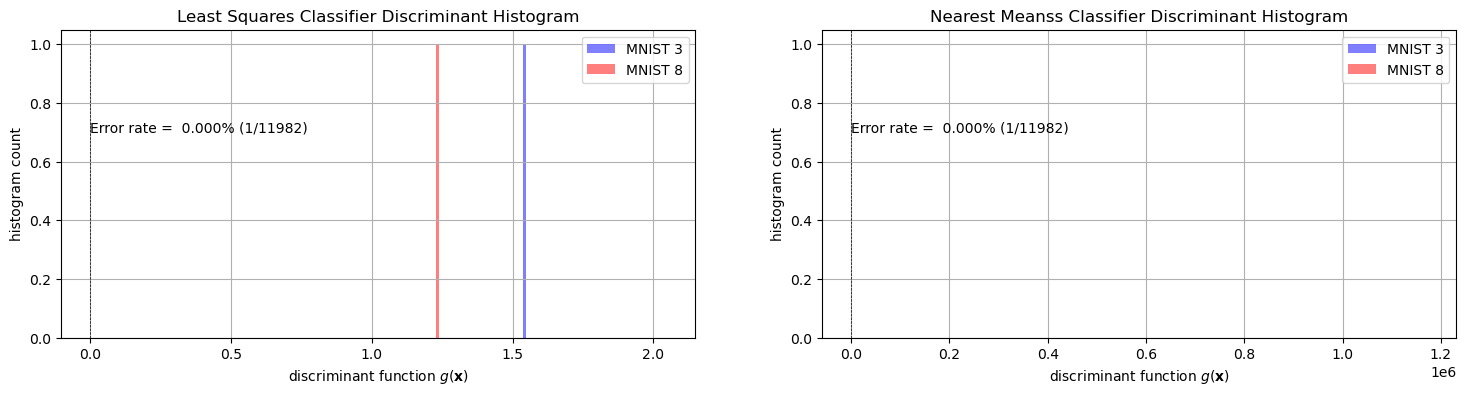

In [16]:
from utils.previous_notebooks import solve_plot_ls_nm_classifier


w_ls, w_nm, MCR_ls, MCR_nm = solve_plot_ls_nm_classifier(x12_train, y12_train, class_labels=[c1, c2], class_names=[f'{tag_name} {c1}', f'{tag_name} {c2}'])

print(f'Misclassification Rate for MSE: {MCR_ls : 0.2f}%')
print(f'Misclassification Rate for NMC: {MCR_nm : 0.2f}%')